In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import scipy.stats as stats
import pandas as pd

In [139]:
def fluorescence_to_chla_conc(data):
    return data # implement later 

def csv_to_xarray(filepath):
    return pd.read_csv(filepath).to_xarray()

def mask_CTD_above_water(ds, method='depth'):
    ''' Given an xarray Dataset of CTD data, try to find bad data 
        (taken above surface before deployment) and mask it out '''
    
    if method == 'depth':
        return ds.where(ds.depth > 0.5, drop=True)
    
def mask_faulty_chlorophyll(da):
    ''' Given an xarray DataArray of chlorophyll fluorescence data (V),
        find bad data due to instrument error and mask it out '''
    
    threshold = 0.08 # if voltage exceeds this value, it's probably wrong 
    return da.where(da < threshold, drop=False) 

def process_raw_toyo(filepath):
    ds_raw = csv_to_xarray(filepath)

    # convert date and time to np.datetime64 objects
    datetimes = []
    for i in range(len(ds_raw.Time)):
        datetimes.append(np.datetime64(f'{ds_raw.Date[i].data}T{ds_raw.Time[i].data}'))
    
    # data variables
    temperature = ds_raw.Temp
    salinity = ds_raw.Salinity
    pressure = ds_raw.Pres
    
    # try to remove bad fluorescence readings due to instrument error
    fluorescenceV = mask_faulty_chlorophyll(ds_raw.Vlt)

    # get the metadata from filename
    filename_parts = filepath.split('/')[-1].split('_')

    ds = xr.Dataset(
        data_vars=dict(
            temp=('time', ds_raw.Temp.data),
            salinity=('time', ds_raw.Salinity.data),
            depth=('time', ds_raw.Depth.data),
            pres=('time', ds_raw.Pres.data),
            chlorophyll=('time', fluorescence_to_chla_conc(fluorescenceV.data)),
        ),
        coords=dict(
            time=datetimes
        ),
        attrs=dict(
            cruise=filename_parts[0],
            station=filename_parts[1],
            tow=filename_parts[2][3],
            description=""
        )
    )

    # try to remove bad data taken above water surface 
    ds = mask_CTD_above_water(ds, method='depth')

    return ds
    
toyo2 = process_raw_toyo('../RCS data backup/Data/S315_010_TOW2derived_copy.csv')
toyo3 = process_raw_toyo('../RCS data backup/Data/S315_012_TOW3derived_copy.csv')
toyo4 = process_raw_toyo('../RCS data backup/Data/S315_013_TOW4derived_copy.csv')

toyo2

<xarray.Dataset>
Dimensions:      (time: 7244)
Coordinates:
  * time         (time) datetime64[ns] 2024-05-18T05:52:58 ... 2024-05-18T07:...
Data variables:
    temp         (time) float64 29.49 29.49 29.49 29.49 ... 29.5 29.51 29.51
    salinity     (time) float64 35.14 35.14 35.15 35.14 ... 35.3 35.3 35.29 35.3
    depth        (time) float64 0.7602 1.045 1.165 ... 0.5757 0.6145 0.5183
    pres         (time) float64 10.9 11.19 11.31 11.39 ... 10.71 10.75 10.66
    chlorophyll  (time) float64 0.0234 0.023 0.0241 0.0234 ... 0.0124 0.012 nan
Attributes:
    cruise:       S315
    station:      010
    tow:          2
    description:

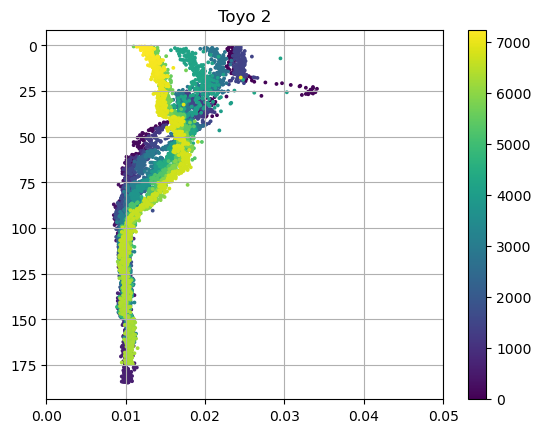

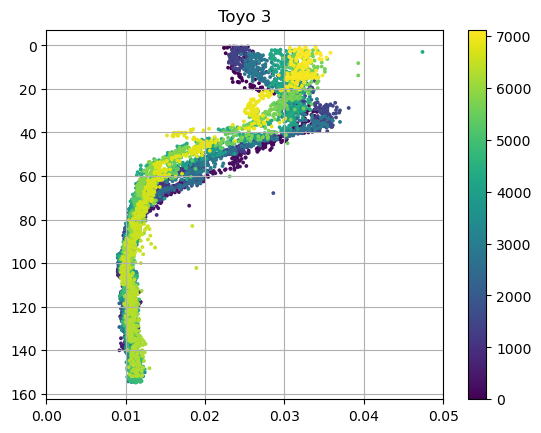

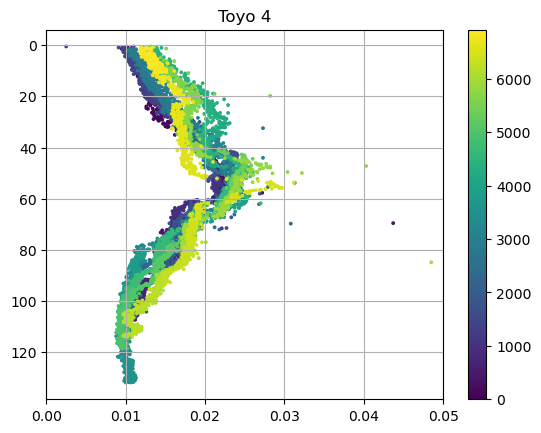

In [140]:
plt.scatter(toyo2.chlorophyll, toyo2.depth, 
            c=np.arange(0, len(toyo2.time)), s=3)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Toyo 2')
plt.xlim(0,0.05)
plt.show()

plt.scatter(toyo3.chlorophyll, toyo3.depth, 
            c=np.arange(0, len(toyo3.time)), s=3)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Toyo 3')
plt.xlim(0,0.05)
plt.show()

plt.scatter(toyo4.chlorophyll, toyo4.depth, 
            c=np.arange(0, len(toyo4.time)), s=3)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Toyo 4')
plt.xlim(0,0.05)
plt.show()


In [145]:
toyo3

<xarray.Dataset>
Dimensions:      (time: 7121)
Coordinates:
  * time         (time) datetime64[ns] 2024-05-18T18:57:48 ... 2024-05-18T20:...
Data variables:
    temp         (time) float64 29.5 29.5 29.51 29.5 ... 29.46 29.46 29.45 29.45
    salinity     (time) float64 35.06 35.08 35.07 35.08 ... 35.22 35.22 35.22
    depth        (time) float64 0.5273 0.6005 0.5243 ... 1.077 0.9363 0.5161
    pres         (time) float64 10.66 10.74 10.66 10.68 ... 11.22 11.08 10.65
    chlorophyll  (time) float64 0.0254 0.0239 0.0236 ... 0.0307 0.0319 0.0339
Attributes:
    cruise:       S315
    station:      012
    tow:          3
    description: